# 基于朴素贝叶斯的垃圾邮件分类

使用sklearn包下的朴素贝叶斯算法，它包含三种模型——高斯模型、多项式模型和伯努利模型，详情可以参考[朴素贝叶斯 — scikit-learn 0.18.1 documentation](http://sklearn.lzjqsdd.com/modules/naive_bayes.html)。  
本文将使用贝叶斯多项式模型类来解决英文邮件分类的问题。

# 导入各种包

In [1]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer

%matplotlib inline

# 数据集

数据来自[Spam Mails Dataset kaggle](https://www.kaggle.com/venky73/spam-mails-dataset)，其中正常邮件标记为ham/0，垃圾邮件为spam/1

In [2]:
data = pd.read_csv('spam_ham_dataset.csv')
data = data.iloc[:, 1:]
data.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
label        5171 non-null object
text         5171 non-null object
label_num    5171 non-null int64
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [4]:
print('这份数据包含{}条邮件'.format(data.shape[0]))

这份数据包含5171条邮件


正常邮件一共有3672条
垃圾邮件一共有1499条


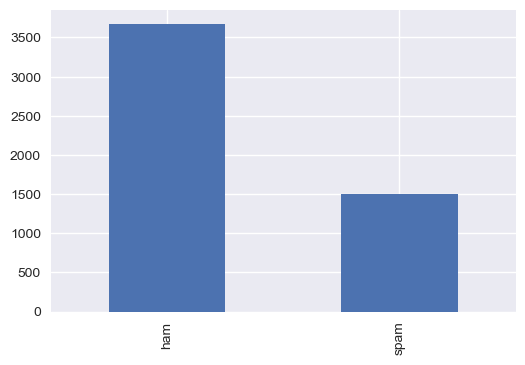

In [5]:
print('正常邮件一共有{}条'.format(data['label_num'].value_counts()[0]))
print('垃圾邮件一共有{}条'.format(data['label_num'].value_counts()[1]))

plt.style.use('seaborn')
plt.figure(figsize=(6, 4), dpi=100)
data['label'].value_counts().plot(kind='bar')

# 新建DataFrame

新建一个DataFrame，所有的处理都在它里面进行

In [6]:
# 只需要text与label_num
new_data = data.iloc[:, 1:]
length = len(new_data)
print('邮件数量 length =', length)
new_data.head()

邮件数量 length = 5171


,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


查看部分具体内容

In [7]:
for i in range(3):
    print(i, '\n', data['text'][i])

0 
 Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .
1 
 Subject: hpl nom for january 9 , 2001
( see attached file : hplnol 09 . xls )
- hplnol 09 . xls
2 
 Subject: neon retreat
ho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !
i know that this time of year is extremely hectic , and that it ' s tough to think about anything past the holidays , but life does go on past the week of december 25 through january 1 , and that ' s what i ' d like you to think about for a minute .
on the calender that i handed out at the beginning of the fall semester , the retreat was scheduled for the weekend of january 5 - 6 . but because of a youth ministers conference that brad and dust

## 预处理

### 大小写

邮件中含有大小写，故将先单词替换为小写

In [8]:
new_data['text'] = new_data['text'].str.lower()
new_data.head()

,text,label_num
0,subject: enron methanol ; meter # : 988291\r\n...,0
1,"subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"subject: photoshop , windows , office . cheap ...",1
4,subject: re : indian springs\r\nthis deal is t...,0


### 停用词

使用停用词，邮件中出现的you、me、be等单词对分类没有影响，故可以将其禁用。还要注意的是所有邮件的开头中都含有单词subject（主题），我们也将其设为停用词。这里使用自然语言处理工具包nltk下的stopwords

In [9]:
stop_words = set(stopwords.words('english'))
stop_words.add('subject')

### 分词

提取一长串句子中的每个单词，并且还要过滤掉各种符号，所以这里使用nltk下的RegexpTokenizer()函数，参数为正则表达式，例如：

In [10]:
string = 'I have a pen,I have an apple. (Uhh~)Apple-pen!' # 来自《PPAP》的歌词
RegexpTokenizer('[a-zA-Z]+').tokenize(string) # 过滤了所有的符号，返回一个列表

['I', 'have', 'a', 'pen', 'I', 'have', 'an', 'apple', 'Uhh', 'Apple', 'pen']

### 词形还原

在英语里面，一个单词有不同的时态，比如love与loves，只是时态不同，但是是同一个意思，于是就有了——词形还原与词干提取。而本文使用的词形还原方法。详情可以参考：[词形还原工具对比 · ZMonster's Blog](http://www.zmonster.me/2016/01/21/lemmatization-survey.html)

这里先使用nltk包下的WordNetLemmatizer()函数，例如：

In [11]:
word = 'loves'
print('{}的原形为{}'.format(word, WordNetLemmatizer().lemmatize(word)))

loves的原形为love


把上面的所有操作一起实现，使用pandas的apply

In [12]:
def text_process(text):
    tokenizer = RegexpTokenizer('[a-z]+') # 只匹配单词，由于已经全为小写，故可以只写成[a-z]+
    lemmatizer = WordNetLemmatizer()
    token = tokenizer.tokenize(text) # 分词
    token = [lemmatizer.lemmatize(w) for w in token if lemmatizer.lemmatize(w) not in stop_words] # 停用词+词形还原
    return token

In [13]:
new_data['text'] = new_data['text'].apply(text_process)

现在我们得到了一个比较干净的数据集了

In [14]:
new_data.head()

,text,label_num
0,"[enron, methanol, meter, follow, note, gave, m...",0
1,"[hpl, nom, january, see, attached, file, hplno...",0
2,"[neon, retreat, ho, ho, ho, around, wonderful,...",0
3,"[photoshop, window, office, cheap, main, trend...",1
4,"[indian, spring, deal, book, teco, pvr, revenu...",0


# 训练集与测试集

将处理后的数据集分为训练集与测试集，比例为3:1

In [15]:
seed = 20190524 # 让实验具有重复性
X = new_data['text']
y = new_data['label_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed) # 75%作为训练集与25%作为测试集

In [16]:
train = pd.concat([X_train, y_train], axis=1) # 训练集
test = pd.concat([X_test, y_test], axis=1) # 测试集

train.reset_index(drop=True, inplace=True) # 重设下标
test.reset_index(drop=True, inplace=True) # 同上

In [17]:
print('训练集含有{}封邮件，测试集含有{}封邮件'.format(train.shape[0], test.shape[0]))

训练集含有3878封邮件，测试集含有1293封邮件


训练集中的垃圾邮件与正常邮件的数量

0    2769
1    1109
Name: label_num, dtype: int64


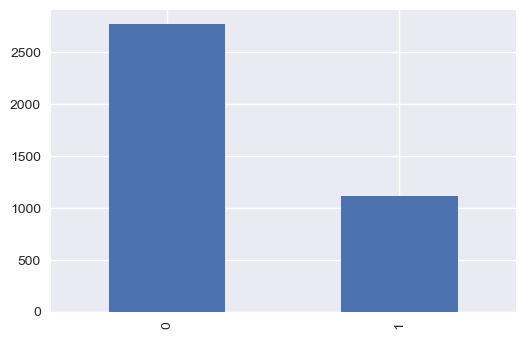

In [18]:
print(train['label_num'].value_counts())
plt.figure(figsize=(6, 4), dpi=100)
train['label_num'].value_counts().plot(kind='bar')

测试集中的垃圾邮件与正常邮件的数量

0    903
1    390
Name: label_num, dtype: int64


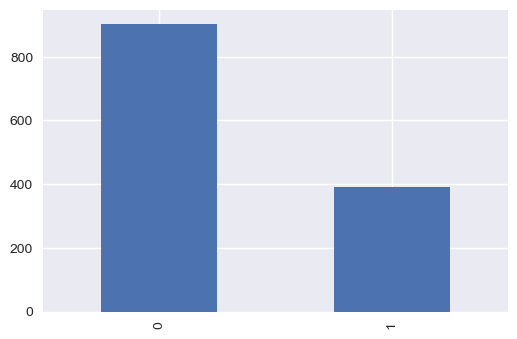

In [19]:
print(test['label_num'].value_counts())
plt.figure(figsize=(6, 4), dpi=100)
test['label_num'].value_counts().plot(kind='bar')

# 特征工程

如果把所有的单词都拿来统计，单词表里面的单词还是比较多的，这样让我们的模型跑起来也是比较慢的，故这里随机抽取正常邮件与垃圾邮件各10封内的单词作为单词表

In [20]:
ham_train = train[train['label_num'] == 0] # 正常邮件
spam_train = train[train['label_num'] == 1] # 垃圾邮件

ham_train_part = ham_train['text'].sample(10, random_state=seed) # 随机抽取的10封正常邮件
spam_train_part = spam_train['text'].sample(10, random_state=seed) # 随机抽取的10封垃圾邮件

part_words = [] # 部分的单词
for text in pd.concat([ham_train_part, spam_train_part]):
    part_words += text

In [21]:
part_words_set = set(part_words)
print('单词表一共有{}个单词'.format(len(part_words_set)))

单词表一共有1528个单词


这就大大减少了单词量

### CountVectorizer

接下来我们要统计每个单词出现的次数，使用sklearn的CountVectorizer()函数，如：

In [22]:
words = ['This is the first sentence', 'And this is the second sentence']
cv = CountVectorizer() # 参数lowercase=True，将字母转为小写，但数据已经是小写了
count = cv.fit_transform(words)
print('cv.vocabulary_:\n', cv.vocabulary_) # 返回一个字典
print('cv.get_feature_names:\n', cv.get_feature_names()) # 返回一个列表
print('count.toarray:\n', count.toarray()) # 返回序列

cv.vocabulary_:
 {'this': 6, 'is': 2, 'the': 5, 'first': 1, 'sentence': 4, 'and': 0, 'second': 3}
cv.get_feature_names:
 ['and', 'first', 'is', 'second', 'sentence', 'the', 'this']
count.toarray:
 [[0 1 1 0 1 1 1]
 [1 0 1 1 1 1 1]]


[0 1 1 0 1 1 1] 对应 ['and', 'first', 'is', 'second', 'sentence', 'the', 'this']，即'first'出现1次，'is'出现1次，如此类推

### TfidfTransformer

接下来还要计算TF-IDF，它反映了单词在文本中的重要程度。使用sklearn包下的TfidfTransformer()，如：

In [23]:
tfidf = TfidfTransformer()
tfidf_matrix = tfidf.fit_transform(count)
print('idf:\n', tfidf.idf_) # 查看idf
print('tfidf:\n', tfidf_matrix.toarray()) # 查看tf-idf

idf:
 [1.40546511 1.40546511 1.         1.40546511 1.         1.
 1.        ]
tfidf:
 [[0.         0.57496187 0.4090901  0.         0.4090901  0.4090901
  0.4090901 ]
 [0.49844628 0.         0.35464863 0.49844628 0.35464863 0.35464863
  0.35464863]]


可以看到 [0 1 1 0 1 1 1] 变为了 [0.         0.57496187 0.4090901  0.         0.4090901  0.4090901 0.4090901 ]


### 添加新一列

现在正式开始各种计算，但是开始之前先把单词整理成句子，就是CountVectorizer认识的格式

In [24]:
# 将正常邮件与垃圾邮件的单词都整理为句子，单词间以空格相隔，CountVectorizer()的句子里，单词是以空格分隔的
train_part_texts = [' '.join(text) for text in np.concatenate((spam_train_part.values, ham_train_part.values))]
# 训练集所有的单词整理成句子
train_all_texts = [' '.join(text) for text in train['text']]
# 测试集所有的单词整理成句子
test_all_texts = [' '.join(text) for text in test['text']]

In [25]:
train_part_texts[: 5]
# train_all_texts[: 5]

['copy everything easy download disc duplicator saw mill river road suite ardsley new york taken future mailing please see link image load please g oh e r e p box g p shahalam shahalam selangord e malaysia',
 'smallcap cribsheet investor alert immediate release investor alert breakout forecast tuesday july ready run running big winner china world trade corp cwtd china world trade corp current price projection day projection day see company president john hui interview cnn asia also look new cnn interview tremendous month company growth completed forward plan dominate china travel industry chinese expedia com china world trade outbid ctrp acquisition new generation southern china largest travel company chairman tsang formerly gold lion holding ha taken rein cwtd continuing record success cwtd stay read news china world trade corporation establishes international business center enhance business service division monday guangzhou china july xinhua prnewswire firstcall china world trade co

In [26]:
cv = CountVectorizer()
part_fit = cv.fit(train_part_texts) # 以部分句子为参考
train_all_count = cv.transform(train_all_texts) # 对训练集所有邮件统计单词个数
test_all_count = cv.transform(test_all_texts) # 对测试集所有邮件统计单词个数
tfidf = TfidfTransformer()
train_tfidf_matrix = tfidf.fit_transform(train_all_count)
test_tfidf_matrix = tfidf.fit_transform(test_all_count)

In [27]:
print('训练集', train_tfidf_matrix.shape)
print('测试集', test_tfidf_matrix.shape)

训练集 (3878, 1513)
测试集 (1293, 1513)


## Tfidf DataFrame

为了让我们的数据看着更舒服一点，创建一个新的DataFrame（可以省略的一步）

In [79]:
train_tfidf_df = pd.DataFrame(train_tfidf_matrix.toarray(), columns=cv.get_feature_names())
train_tfidf_df.head()

,abate,abater,ability,abominate,aborigine,abram,abuse,ac,acceptance,accessory,...,xual,xylene,yeager,yeah,yellowstone,york,yvette,yvonne,zenith,zesty
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
test_tfidf_df = pd.DataFrame(test_tfidf_matrix.toarray(), columns=cv.get_feature_names())
test_tfidf_df.head()

,abate,abater,ability,abominate,aborigine,abram,abuse,ac,acceptance,accessory,...,xual,xylene,yeager,yeah,yellowstone,york,yvette,yvonne,zenith,zesty
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 建立模型

In [28]:
mnb = MultinomialNB()
mnb.fit(train_tfidf_matrix, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

模型在测试集上的正确率

In [29]:
mnb.score(test_tfidf_matrix, y_test)

0.9265274555297757

In [30]:
y_pred = mnb.predict_proba(test_tfidf_matrix)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
auc = auc(fpr, tpr)

Text(0, 0.5, 'tpr')

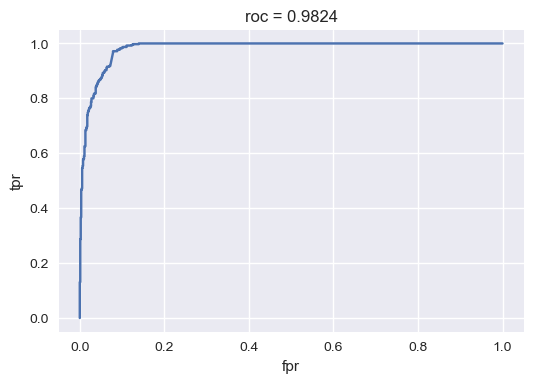

In [34]:
# roc 曲线
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(fpr, tpr)
plt.title('roc = {:.4f}'.format(auc))
plt.xlabel('fpr')
plt.ylabel('tpr')

到此，就完成了从数据清理到建模的一整套流程了，当然其中还要许多东西可以完善的。

# 参考资料

1. [朴素贝叶斯 — scikit-learn 0.18.1 documentation](http://sklearn.lzjqsdd.com/modules/naive_bayes.html)
2. [词形还原工具对比 · ZMonster's Blog](http://www.zmonster.me/2016/01/21/lemmatization-survey.html)
3. [Countvectorizer sklearn example - A Data Analyst](https://adataanalyst.com/scikit-learn/countvectorizer-sklearn-example/)
4. [sklearn——朴素贝叶斯文本分类](https://blog.csdn.net/panghaomingme/article/details/54428030)
5. [sklearn 实现中文数据集的垃圾邮件分类](https://zhuanlan.zhihu.com/p/49040330)